# Zigzagを求めてみる

とりあえずソフトバンク株をサンプルにZigzagを計算してみる。
参考にしたのは
[ここ](http://exceltechnical.web.fc2.com/zigzag.html)

## データの整形
カラム名がTradingViewに合わせてあるので、mplfinance用にカラム名を修正。大文字小文字が違ってもNG。
でも、順番はなんでも可。

In [1]:
import sqlite3 as sql
import pandas as pd

code = 9434 #ソフトバンク
con = sql.connect('/workspaces/stock/src/db.sqlite')
try:
    cur = con.cursor()
    df = pd.read_sql_query(f'SELECT date as Date, open as Open, high as High, low as Low, close as Close, volume as Volume FROM History WHERE code = {code}', con)
finally:
    con.close() 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df)
df.to_csv(f'{code}.csv')

              Open    High     Low   Close    Volume
Date                                                
2023-01-04  1495.5  1499.5  1489.0  1499.0   6331900
2023-01-05  1496.5  1499.5  1488.0  1492.5   5610700
2023-01-06  1494.0  1494.0  1485.5  1490.0   4760400
2023-01-10  1486.0  1488.0  1465.5  1465.5  11604400
2023-01-11  1470.5  1476.0  1462.5  1463.0   8948700
...            ...     ...     ...     ...       ...
2024-04-04  1920.0  1936.0  1919.0  1923.0   5860100
2024-04-05  1918.0  1923.0  1907.0  1921.0   4698400
2024-04-08  1915.0  1926.5  1912.5  1918.5   4905200
2024-04-09  1917.5  1924.0  1894.0  1898.5   6048100
2024-04-10  1888.0  1892.5  1870.0  1870.0   6289200

[312 rows x 5 columns]


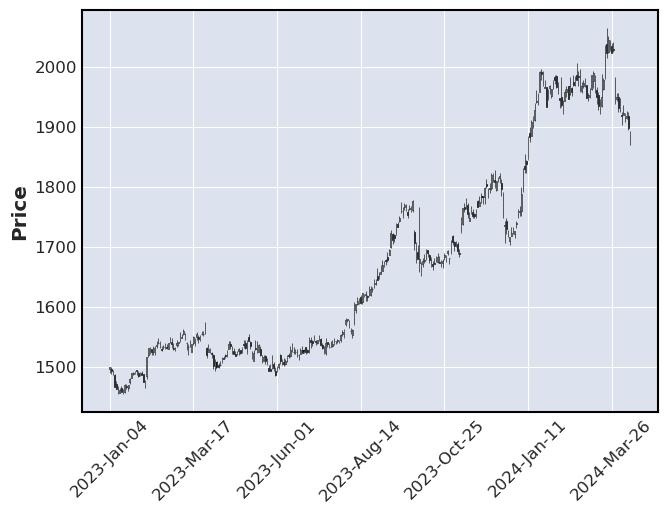

In [2]:
import mplfinance as mpf
mpf.plot(df, type='candle')
mpf.show()

## zigzag計算

本丸のzigzag計算。

Switch列には次の転換日が入っている。(zigzagには不要だが、利益率とか考えるうえで期間は必要かなと)

In [3]:
cp: float = 0.02
prev_trend = 1
prev_provisional = df.Close.iat[0]

trend = []
provisional = []

for c in df.Close:
    change = (c - prev_provisional) / prev_provisional
    cur_trend = 1 if change > cp \
        else -1 if change < -cp \
        else prev_trend
    cur_provisional = abs(max(cur_trend * c, cur_trend * prev_provisional))
    trend.append(cur_trend)
    provisional.append(cur_provisional)
    prev_trend = cur_trend
    prev_provisional = cur_provisional

df['Trend'] = trend
df['Provisional'] = provisional

fixed = []
switch = []
zigzag = []
cur_fixed = 0
prev_fixed = provisional[-1]
prev_switch = df.index[-1]
for r in df.iloc[::-1].itertuples():
    cur_fixed = abs(max(r.Trend * r.Provisional, r.Trend * prev_fixed))
    fixed.append(cur_fixed)
    prev_fixed = cur_fixed
    switch.append(prev_switch)
    if r.Close == cur_fixed:
        prev_switch = r.Index
        zigzag.append(cur_fixed)
    else:
        zigzag.append(None)

fixed.reverse()
switch.reverse()
zigzag.reverse()
df['Fixed'] = fixed
df['Zigzag'] = zigzag
df['Switch'] = switch

# zigzag = df.query('Close == Fixed')
print(df.loc[:, ['Close', 'Trend', 'Provisional', 'Fixed', 'Zigzag', 'Switch']])
df.to_csv('zigzag.csv')



             Close  Trend  Provisional   Fixed  Zigzag     Switch
Date                                                             
2023-01-04  1499.0      1       1499.0  1499.0  1499.0 2023-01-16
2023-01-05  1492.5      1       1499.0  1499.0     NaN 2023-01-16
2023-01-06  1490.0      1       1499.0  1499.0     NaN 2023-01-16
2023-01-10  1465.5     -1       1465.5  1458.0     NaN 2023-01-16
2023-01-11  1463.0     -1       1463.0  1458.0     NaN 2023-01-16
...            ...    ...          ...     ...     ...        ...
2024-04-04  1923.0     -1       1918.0  1870.0     NaN 2024-04-10
2024-04-05  1921.0     -1       1918.0  1870.0     NaN 2024-04-10
2024-04-08  1918.5     -1       1918.0  1870.0     NaN 2024-04-10
2024-04-09  1898.5     -1       1898.5  1870.0     NaN 2024-04-10
2024-04-10  1870.0     -1       1870.0  1870.0  1870.0 2024-04-10

[312 rows x 6 columns]


で、可視化。

mplfinanceの仕様上、サンプリング数を合わせなきゃいけないらしいので、飛び飛びになっているZigzag列を線形補間してやる。

Date
2023-01-04    1499.000000
2023-01-05    1493.142857
2023-01-06    1487.285714
2023-01-10    1481.428571
2023-01-11    1475.571429
                 ...     
2024-04-04    1923.846154
2024-04-05    1910.384615
2024-04-08    1896.923077
2024-04-09    1883.461538
2024-04-10    1870.000000
Name: Zigzag, Length: 312, dtype: float64


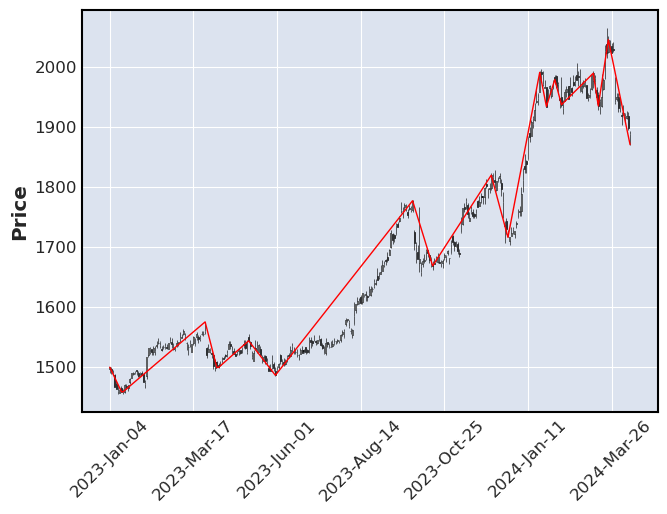

In [4]:
df['Zigzag'].interpolate(inplace=True)
series = [
    mpf.make_addplot(df['Zigzag'], color='#FF0000', width=1, linestyle='solid')
]
print(df['Zigzag'])
mpf.plot(df, type='candle', addplot=series)



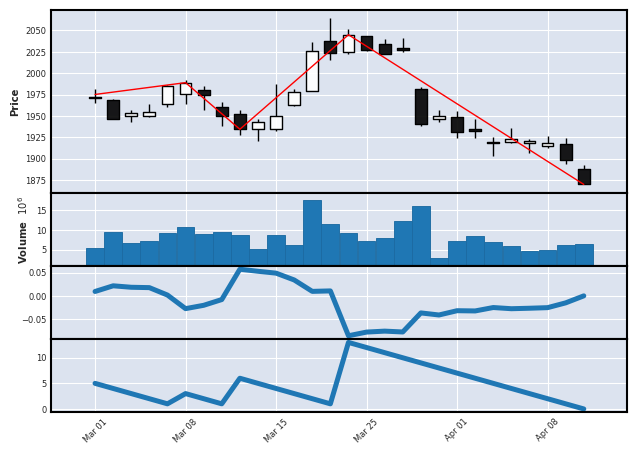

In [8]:
expected = []
period = []
for row in df.itertuples():
    profit = df.at[row.Switch, 'Close'] - row.Close
    expected.append(profit / row.Close)
    period.append(df.index.get_loc(row.Switch) - df.index.get_loc(row.Index))

df['Expected'] = expected
df['Period'] = period
df = df['2024-03-01':]
series = [
    mpf.make_addplot(df['Zigzag'], color='#FF0000', width=1, linestyle='solid'),
    mpf.make_addplot(df['Expected'], panel=2),
    mpf.make_addplot(df['Period'], panel=3),
]
mpf.plot(df, type='candle', addplot=series, volume=True, fontscale=0.5)
